# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [1419]:
import bson
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pyreadr
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn import tree, ensemble
import sys
import time
import importlib


In [1554]:
importlib.reload(sys.modules['data_accessor'])

from data_accessor import load_twibot, load_bot_repo_dataset, load_cresci, load_cresci2017, load_cresci2015, load_caverlee, load_emd, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df, load_other_bots, load_spammers, get_intraclass_labels, load_human_dataset_list, load_fake_followers, load_other_bots
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, train_test_fit_and_score_clf, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from train_on_one_test_on_another import train_on_one_test_on_another
from unused_data import remove_trailing_zero


In [586]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_dataset_name(df):
    try:
        return namestr(df, globals())[0]
    except:
        return "Unknown"


## Load datasets and calculate scores

## Profile data

In [1287]:
# Twibot
twibot_df, twibot_2020_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_2020_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
#twibot_validate, twibot_2020_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
shared_columns = set.intersection(set(twibot_2020_one_hot.columns), set(twibot_2020_one_hot_test.columns)) # Since we want to check on test set, just use common columns between train/test.
twibot_scores = []
for i in range(1, 6):
    dt_clf = fit(twibot_2020_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_2020_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    # balanced
    baccs = []
    iters = 5
    for j in range(iters):
        twibot_2020_humans = twibot_2020_one_hot[pd.Series(twibot_labels) == 0]
        twibot_2020_bots = twibot_2020_one_hot[pd.Series(twibot_labels) == 1]
        n_accts = min(len(twibot_2020_humans), len(twibot_2020_bots))
        btwibot_labels = [0]*n_accts + [1]*n_accts
        bal_clf = fit(pd.concat([twibot_2020_humans.sample(n_accts), twibot_2020_bots.sample(n_accts)])[shared_columns], btwibot_labels, depth=i)
        twibot_2020_humans_test = twibot_2020_one_hot[pd.Series(twibot_labels) == 0]
        twibot_2020_bots_test = twibot_2020_one_hot[pd.Series(twibot_labels) == 1]
        n_accts_test = min(len(twibot_2020_humans_test), len(twibot_2020_bots_test))
        btwibot_labels_test = [0]*n_accts_test + [1]*n_accts_test
        bacc, *_ = score(bal_clf, pd.concat([twibot_2020_humans_test.sample(n_accts_test), twibot_2020_bots_test.sample(n_accts_test)])[shared_columns], btwibot_labels_test, silent=True)
        baccs = baccs + [bacc]
    mean_bacc = sum(baccs)/iters
    twibot_scores.append(list(scr) + [mean_bacc])
    

In [1382]:
# botometer-feedback
bf, botometer_feedback_2019_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(botometer_feedback_2019_one_hot, bf_labels, silent=True)

Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.5428152. Execution time: 0.11285829544067383 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.631188. Execution time: 0.0882866382598877 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.721704. Execution time: 0.09042239189147949 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.8225932. Execution time: 0.10079145431518555 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.9195182. Execution time: 0.09683680534362793 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172038.0038977. Execution time: 0.08427214622497559 s
Starting kfold_cv at 10/07/22 15:47:18
Finished kfold_cv at 1665172038.0875986. Execution time: 0.0836031436920166 s
Starting kfold_cv at 10/07/22 15:47:18
Finished kfold_cv at 1665172038.1739025. Execution time: 0.0862126350402832 s
Starting kfold_cv at 10/07/22 15:47:18
Finished kfold_cv at 1

In [1384]:
# botometer-feedback
bf, botometer_feedback_2019_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(botometer_feedback_2019_one_hot, bf_labels, silent=True)

#rtbust
rtbust, cresci_rtbust_2019_one_hot, rtbust_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_bot_repo_dataset(cresci_rtbust_2019_one_hot, rtbust_labels, silent=True)

#gilani-2017
gilani, gilani_2017_one_hot, gilani_labels = load_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_bot_repo_dataset(gilani_2017_one_hot, gilani_labels, silent=True)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_bot_repo_dataset(gilani_derived_df, gilani_derived_label, silent=True) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(5)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci_2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_bot_repo_dataset(cresci_2017_one_hot, cresci2017_labels, silent=True)

#cresci-2015
cresci2015, cresci_2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_bot_repo_dataset(cresci_2015_one_hot, cresci2015_labels, silent=True)

#caverlee-2011
caverlee_2011, caverlee_2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee_2011_scores = analyze_bot_repo_dataset(caverlee_2011, caverlee_2011_labels, silent=True)

#cresci-stock-2018
cresci_stock, cresci_stock_2018_one_hot, cresci_stock_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_bot_repo_dataset(cresci_stock_2018_one_hot, cresci_stock_labels, silent=True)


Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.2065978. Execution time: 0.10977339744567871 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.2949648. Execution time: 0.08828091621398926 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.386158. Execution time: 0.09111380577087402 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.4800096. Execution time: 0.09377241134643555 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.5773191. Execution time: 0.09720706939697266 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.6640503. Execution time: 0.08663821220397949 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.7479987. Execution time: 0.08386349678039551 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.83296. Execution time: 0.0848689079284668 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 

Starting kfold_cv at 10/07/22 15:47:51
Finished kfold_cv at 1665172075.0853748. Execution time: 3.3997609615325928 s
Starting kfold_cv at 10/07/22 15:47:55
Finished kfold_cv at 1665172079.0394192. Execution time: 3.953845500946045 s
Starting kfold_cv at 10/07/22 15:47:59
Finished kfold_cv at 1665172083.4095664. Execution time: 4.369809627532959 s
Starting kfold_cv at 10/07/22 15:48:03
Finished kfold_cv at 1665172088.132686. Execution time: 4.722923278808594 s
Starting kfold_cv at 10/07/22 15:48:08
Finished kfold_cv at 1665172093.2033992. Execution time: 5.070523262023926 s
Starting kfold_cv at 10/07/22 15:48:13
Finished kfold_cv at 1665172095.469055. Execution time: 2.265408754348755 s
Starting kfold_cv at 10/07/22 15:48:15
Finished kfold_cv at 1665172097.9366274. Execution time: 2.4673852920532227 s
Starting kfold_cv at 10/07/22 15:48:17
Finished kfold_cv at 1665172100.5253565. Execution time: 2.5884008407592773 s
Starting kfold_cv at 10/07/22 15:48:20
Finished kfold_cv at 1665172103.

In [1385]:
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/pronbots-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_bot_repo_dataset(PROJ_PATH + "/data/vendor-purchased-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
#verified
verified_df, verified_one_hot, verified_labels = load_bot_repo_dataset(PROJ_PATH + "/data/verified-2019_tweets.json", PROJ_PATH + "/data/verified-2019.tsv")

# EMD
ersahin_2017, ersahin_2017_labels = load_emd(PROJ_PATH + '/data/EMD-2017/Twitter_dataset.arff') # Load data

In [1468]:
midterm, midterm_2018_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_bot_repo_dataset(midterm_2018_one_hot, midterm_labels, kfold=True, silent=True)

Starting kfold_cv at 10/07/22 20:57:25
Finished kfold_cv at 1665190765.7410672. Execution time: 119.8400571346283 s
Starting kfold_cv at 10/07/22 20:59:25
Finished kfold_cv at 1665190911.1040764. Execution time: 145.3626115322113 s
Starting kfold_cv at 10/07/22 21:01:51
Finished kfold_cv at 1665191075.9992988. Execution time: 164.8948392868042 s
Starting kfold_cv at 10/07/22 21:04:35
Finished kfold_cv at 1665191258.3983605. Execution time: 182.39867401123047 s
Starting kfold_cv at 10/07/22 21:07:38
Finished kfold_cv at 1665191461.331026. Execution time: 202.93226981163025 s
Starting kfold_cv at 10/07/22 21:11:01
Finished kfold_cv at 1665191515.917934. Execution time: 54.586514711380005 s
Starting kfold_cv at 10/07/22 21:11:55
Finished kfold_cv at 1665191573.6848295. Execution time: 57.766562700271606 s
Starting kfold_cv at 10/07/22 21:12:53
Finished kfold_cv at 1665191632.841085. Execution time: 59.15593409538269 s
Starting kfold_cv at 10/07/22 21:13:52
Finished kfold_cv at 1665191693.

In [1387]:
yang, yang_2013_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_bot_repo_dataset(yang_2013_one_hot, yang_labels)

Starting kfold_cv at 10/07/22 15:55:57
Finished kfold_cv at 1665172577.4899294. Execution time: 20.307188749313354 s
Starting kfold_cv at 10/07/22 15:56:17
Finished kfold_cv at 1665172601.1247098. Execution time: 23.63442325592041 s
Starting kfold_cv at 10/07/22 15:56:41
Finished kfold_cv at 1665172627.5649817. Execution time: 26.43988800048828 s
Starting kfold_cv at 10/07/22 15:57:07
Finished kfold_cv at 1665172656.6762574. Execution time: 29.11090850830078 s
Starting kfold_cv at 10/07/22 15:57:36
Finished kfold_cv at 1665172687.8315983. Execution time: 31.154962301254272 s
Starting kfold_cv at 10/07/22 15:58:07
Finished kfold_cv at 1665172696.5206883. Execution time: 8.688685178756714 s
Starting kfold_cv at 10/07/22 15:58:16
Finished kfold_cv at 1665172705.0567892. Execution time: 8.535767555236816 s
Starting kfold_cv at 10/07/22 15:58:25
Finished kfold_cv at 1665172713.700738. Execution time: 8.643719673156738 s
Starting kfold_cv at 10/07/22 15:58:33
Finished kfold_cv at 1665172722.

## Tweets data

In [1388]:
yang_tweets, yang_2013_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_bot_repo_dataset(yang_tweets, yang_2013_tweets_labels)


Starting kfold_cv at 10/07/22 16:00:12
Finished kfold_cv at 1665172834.3027408. Execution time: 22.172532081604004 s
Starting kfold_cv at 10/07/22 16:00:34
Finished kfold_cv at 1665172868.593337. Execution time: 34.29038381576538 s
Starting kfold_cv at 10/07/22 16:01:08
Finished kfold_cv at 1665172914.5048594. Execution time: 45.91113066673279 s
Starting kfold_cv at 10/07/22 16:01:54
Finished kfold_cv at 1665172971.9243326. Execution time: 57.41906762123108 s
Starting kfold_cv at 10/07/22 16:02:51
Finished kfold_cv at 1665173040.9974518. Execution time: 69.0727105140686 s
Starting kfold_cv at 10/07/22 16:04:00
Finished kfold_cv at 1665173047.8034902. Execution time: 6.805635213851929 s
Starting kfold_cv at 10/07/22 16:04:07
Finished kfold_cv at 1665173056.563499. Execution time: 8.759685516357422 s
Starting kfold_cv at 10/07/22 16:04:16
Finished kfold_cv at 1665173067.1353765. Execution time: 10.571713209152222 s
Starting kfold_cv at 10/07/22 16:04:27
Finished kfold_cv at 1665173079.05

In [1398]:
pan_2019_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_bot_repo_dataset(pan_2019_df, pan19_labels)


Starting kfold_cv at 10/07/22 16:21:12
Finished kfold_cv at 1665174076.9866495. Execution time: 4.7592926025390625 s
Starting kfold_cv at 10/07/22 16:21:16
Finished kfold_cv at 1665174083.8426266. Execution time: 6.85580039024353 s
Starting kfold_cv at 10/07/22 16:21:23
Finished kfold_cv at 1665174092.866968. Execution time: 9.024145603179932 s
Starting kfold_cv at 10/07/22 16:21:32
Finished kfold_cv at 1665174103.742617. Execution time: 10.875348567962646 s
Starting kfold_cv at 10/07/22 16:21:43
Finished kfold_cv at 1665174116.7194612. Execution time: 12.976686000823975 s
Starting kfold_cv at 10/07/22 16:21:56
Finished kfold_cv at 1665174121.999779. Execution time: 5.2799389362335205 s
Starting kfold_cv at 10/07/22 16:22:01
Finished kfold_cv at 1665174129.27283. Execution time: 7.272893667221069 s
Starting kfold_cv at 10/07/22 16:22:09
Finished kfold_cv at 1665174138.5737078. Execution time: 9.30068850517273 s
Starting kfold_cv at 10/07/22 16:22:18
Finished kfold_cv at 1665174149.8133

In [1409]:
cresci_2017_tweets, cresci_2017_tweets_labels = load_cresci2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci_2017_tweets_scores = analyze_bot_repo_dataset(cresci_2017_tweets, cresci_2017_tweets_labels, silent=True)


/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Starting kfold_cv at 10/07/22 16:35:05
Finished kfold_cv at 1665174954.9184365. Execution time: 49.880038022994995 s
Starting kfold_cv at 10/07/22 16:35:54
Finished kfold_cv at 1665175032.371238. Execution time: 77.45242357254028 s
Starting kfold_cv at 10/07/22 16:37:12
Finished kfold_cv at 1665175135.9345758. Execution time: 103.56292271614075 s
Starting kfold_cv at 10/07/22 16:38:55
Finished kfold_cv at 1665175265.210303. Execution time: 129.27523255348206 s
Starting kfold_cv at 10/07/22 16:41:05
Finished kfold_cv at 1665175420.479958. Execution time: 155.26917791366577 s
Starting kfold_cv at 10/07/22 16:43:40
Finished kfold_cv at 1665175437.6873846. Execution time: 17.206937313079834 s
Starting kfold_cv at 10/07/22 16:43:57
Finished kfold_cv at 1665175460.7004974. Execution time: 23.012733459472656 s
Starting kfold_cv at 10/07/22 16:44:20
Finished kfold_cv at 1665175489.14071. Execution time: 28.43999147415161 s
Starting kfold_cv at 10/07/22 16:44:49
Finished kfold_cv at 1665175520.

In [1463]:
cresci_2015_tweets, cresci_2015_tweets_labels = load_cresci2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci_2015_tweets_scores = analyze_bot_repo_dataset(cresci_2015_tweets, cresci_2015_tweets_labels)


Starting kfold_cv at 10/07/22 19:08:51
Finished kfold_cv at 1665184154.7884285. Execution time: 22.8222439289093 s
Starting kfold_cv at 10/07/22 19:09:14
Finished kfold_cv at 1665184188.7087688. Execution time: 33.919944524765015 s
Starting kfold_cv at 10/07/22 19:09:48
Finished kfold_cv at 1665184230.0455432. Execution time: 41.336352825164795 s
Starting kfold_cv at 10/07/22 19:10:30
Finished kfold_cv at 1665184277.566621. Execution time: 47.52067732810974 s
Starting kfold_cv at 10/07/22 19:11:17
Finished kfold_cv at 1665184331.1072838. Execution time: 53.540247201919556 s
Starting kfold_cv at 10/07/22 19:12:11
Finished kfold_cv at 1665184351.247163. Execution time: 20.139384984970093 s
Starting kfold_cv at 10/07/22 19:12:31
Finished kfold_cv at 1665184379.9488683. Execution time: 28.70150399208069 s
Starting kfold_cv at 10/07/22 19:12:59
Finished kfold_cv at 1665184414.8063323. Execution time: 34.857062101364136 s
Starting kfold_cv at 10/07/22 19:13:34
Finished kfold_cv at 1665184454

In [1466]:
cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels = load_cresci_stock_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_2018_tweets_scores = analyze_bot_repo_dataset(cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels)


Starting kfold_cv at 10/07/22 19:28:31
Finished kfold_cv at 1665185530.5595348. Execution time: 219.55429005622864 s
Starting kfold_cv at 10/07/22 19:32:10
Finished kfold_cv at 1665185879.6709995. Execution time: 349.1110849380493 s
Starting kfold_cv at 10/07/22 19:37:59
Finished kfold_cv at 1665186347.001924. Execution time: 467.33055567741394 s
Starting kfold_cv at 10/07/22 19:45:47
Finished kfold_cv at 1665186928.6136384. Execution time: 581.6113493442535 s
Starting kfold_cv at 10/07/22 19:55:28
Finished kfold_cv at 1665187607.1556137. Execution time: 678.5416028499603 s
Starting kfold_cv at 10/07/22 20:06:47
Finished kfold_cv at 1665187829.6545124. Execution time: 222.4985146522522 s
Starting kfold_cv at 10/07/22 20:10:29
Finished kfold_cv at 1665188168.8007383. Execution time: 339.1456730365753 s
Starting kfold_cv at 10/07/22 20:16:08
Finished kfold_cv at 1665188613.1253679. Execution time: 444.32403469085693 s
Starting kfold_cv at 10/07/22 20:23:33
Finished kfold_cv at 1665189160

In [1472]:
scores = {
    'twibot-2020': twibot_scores, 
    'botometer-feedback-2019': botometer_feedback_scores, 
    'cresci-rtbust-2019': rtbust_scores, 
    'gilani-2017': gilani_derived_scores_avg, 
    'cresci-2017': cresci2017_scores, 
    'cresci-2015': cresci2015_scores, 
    'caverlee-2011': caverlee_2011_scores,
    'midterm-2018': midterm_scores, 
    'yang-2013': yang_scores,
    'cresci-stock-2018': cresci_stock_scores,
    'pan-2019': pan19_scores
}

rows = []

for name, scr in scores.items():
    row = {'name': name}
    print(name)
    for i, (a,p,r,f,ba) in enumerate(scr):
        row.update({
            f'a{i+1}': a,  #accuracy
            f'p{i+1}': p,  #precision
            f'r{i+1}': r,  #recall
            f'f{i+1}': f,  #f1
            f'ba{i+1}': ba #balanced accuracy
        })
    rows.append(row)
    
scores_df = pd.DataFrame(rows)
scores_df.to_csv("scores.csv", index=False)

twibot-2020
botometer-feedback-2019
cresci-rtbust-2019
gilani-2017
cresci-2017
cresci-2015
caverlee-2011
midterm-2018
yang-2013
cresci-stock-2018
pan-2019


# Train on one, test on another

In [1473]:
datasets = [twibot_2020_one_hot, botometer_feedback_2019_one_hot, cresci_rtbust_2019_one_hot, gilani_2017_one_hot, cresci_2017_one_hot, cresci_2015_one_hot, cresci_stock_2018_one_hot, yang_2013_one_hot]
labels = [twibot_labels, bf_labels, rtbust_labels, gilani_labels, cresci2017_labels, cresci2015_labels, cresci_stock_labels, yang_labels]


rows = []

for train_on, train_on_labels in zip(datasets,labels):
    for test_on, test_on_labels in zip(datasets,labels):
        rf = ensemble.RandomForestClassifier()
        rows.append(train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels, get_dataset_name(train_on), get_dataset_name(test_on), method=rf))
        
train_on_one_test_on_another_performance = pd.DataFrame(rows)


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

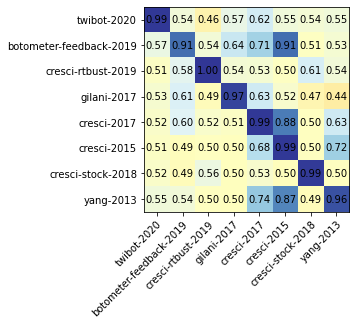

In [1475]:
depth=3
tootoa_a3 = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'accuracy', depth)
tootoa_a3.to_csv(f"tootoa_a{depth}.csv")

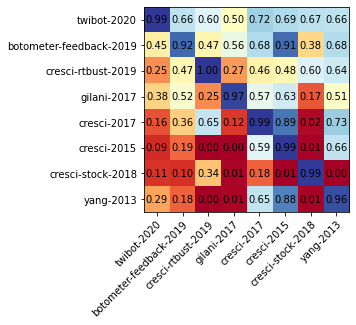

In [1476]:
depth=3
tootoa_f = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'f1', depth)
tootoa_f.to_csv(f"tootoa_f{depth}.csv")

# Leave-one-dataset-out

In [1477]:
cols = list(set.intersection(*map(set,[list(d) for d in datasets])))

rows = []

for i in range(len(datasets)):
    rows.append(leave_dataset_out(i))
    
leave_one_out_scores = pd.DataFrame(rows)

In [1478]:
print_leave_one_out_table(leave_one_out_scores)

twibot-2020 & 0.45/0.18 & 1 \\
botometer-feedback-2019 & 0.65/0.41 & 1 \\
cresci-rtbust-2019 & 0.54/0.37 & 1 \\
gilani-2017 & 0.56/0.14 & 1 \\
cresci-2017 & 0.77/0.84 & 1 \\
cresci-2015 & 0.91/0.94 & 1 \\
cresci-stock-2018 & 0.65/0.66 & 1 \\
yang-2013 & 0.32/0.21 & 1 \\


## Analysis of each of the specialized classifiers in Botometer

In [1479]:
def get_columns(df):
    return df.columns[~df.columns.str.contains('location') & ~df.columns.str.contains('utc') & ~df.columns.str.contains('time_zone')& ~df.columns.str.contains('lang')]



### humans

In [1519]:
human_df_list = load_human_dataset_list()
human_df, human_dataset_class_labels = get_intraclass_labels(human_df_list)


In [1508]:
train_test_fit_and_score(human_df.drop(['created_at'], axis=1), human_dataset_class_labels, depth=3, silent=False, prec_rec=False, balance=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:05:47
|--- followers_count <= 10066.50
|   |--- friends_count <= 0.50
|   |   |--- statuses_count <= 93.50
|   |   |   |--- weights: [130.00, 0.00, 1.00, 7.00, 1.00] class: 0
|   |   |--- statuses_count >  93.50
|   |   |   |--- weights: [236.00, 1.00, 1.00, 10.00, 1487.00] class: 4
|   |--- friends_count >  0.50
|   |   |--- statuses_count <= 10579.00
|   |   |   |--- weights: [14262.00, 193.00, 115.00, 93.00, 2139.00] class: 0
|   |   |--- statuses_count >  10579.00
|   |   |   |--- weights: [703.00, 71.00, 19.00, 334.00, 1184.00] class: 4
|--- followers_count >  10066.50
|   |--- followers_count <= 211627.00
|   |   |--- statuses_count <= 21169.50
|   |   |   |--- weights: [84.00, 18.00, 685.00, 148.00, 27.00] class: 2
|   |   |--- statuses_count >  21169.50
|   |   |   |--- weights: [11.00, 21.00, 159.00, 227.00, 71.00] class: 3
|   |--- followers_count >  211627.00
|   |   |--- followers_count <= 40328740.00
|   |   |   |--- wei

(0.8213478064224333, -1, -1, -1)

In [1509]:
train_test_fit_and_score(human_df.drop(['created_at'], axis=1), human_dataset_class_labels, depth=3, silent=False, prec_rec=False, balance=True)


Starting train_test_fit_and_score_clf at 10/07/22 22:06:07
|--- friends_count <= 374.00
|   |--- followers_count <= 2543.50
|   |   |--- friends_count <= 159.00
|   |   |   |--- weights: [204.00, 51.00] class: 0
|   |   |--- friends_count >  159.00
|   |   |   |--- weights: [51.00, 38.00] class: 0
|   |--- followers_count >  2543.50
|   |   |--- statuses_count <= 1086.50
|   |   |   |--- weights: [2.00, 1.00] class: 0
|   |   |--- statuses_count >  1086.50
|   |   |   |--- weights: [1.00, 12.00] class: 1
|--- friends_count >  374.00
|   |--- followers_count <= 1346.50
|   |   |--- followers_count <= 124.00
|   |   |   |--- weights: [0.00, 18.00] class: 1
|   |   |--- followers_count >  124.00
|   |   |   |--- weights: [38.00, 80.00] class: 1
|   |--- followers_count >  1346.50
|   |   |--- statuses_count <= 879.00
|   |   |   |--- weights: [2.00, 3.00] class: 1
|   |   |--- statuses_count >  879.00
|   |   |   |--- weights: [4.00, 103.00] class: 1

Accuracy: 0.6907894736842105
Precisio

(0.6907894736842105, -1, -1, -1)

### simple bots

In [1618]:

simple_df = caverlee_2011[caverlee_2011_labels.values == 1].rename(columns={'CreatedAt': 'created_at', 'NumerOfFollowings': 'friends_count', 'NumberOfFollowers': 'followers_count', "NumberOfTweets": 'statuses_count'})
simple_df


,created_at,friends_count,followers_count,statuses_count,LengthOfScreenName,LengthOfDescriptionInUserProfile
0,1.158556e+09,3269,3071,861,8,132
1,1.161974e+09,1949,793,226,9,134
2,1.162133e+09,1119,9644,38674,12,158
3,1.168796e+09,2174,6029,12718,11,121
4,1.169954e+09,7731,7029,873,6,70
...,...,...,...,...,...,...
22218,1.280721e+09,63,10,29,12,0
22219,1.280722e+09,83,10,35,8,0
22220,1.280723e+09,67,9,21,13,0
22221,1.280724e+09,35,4,17,12,0


In [1615]:
simple_df

,created_at,NumerOfFollowings,NumberOfFollowers,num_tweets,LengthOfScreenName,LengthOfDescriptionInUserProfile
0,1.158556e+09,3269,3071,861,8,132
1,1.161974e+09,1949,793,226,9,134
2,1.162133e+09,1119,9644,38674,12,158
3,1.168796e+09,2174,6029,12718,11,121
4,1.169954e+09,7731,7029,873,6,70
...,...,...,...,...,...,...
22218,1.280721e+09,63,10,29,12,0
22219,1.280722e+09,83,10,35,8,0
22220,1.280723e+09,67,9,21,13,0
22221,1.280724e+09,35,4,17,12,0


In [1603]:
simple_df.columns

Index(['CreatedAt', 'NumerOfFollowings', 'NumberOfFollowers', 'NumberOfTweets',
       'LengthOfScreenName', 'LengthOfDescriptionInUserProfile'],
      dtype='object')

### spammers

In [1511]:
spammers_intradataset, spammers_labels = load_spammers(intradataset=True)


In [1512]:
train_test_fit_and_score(spammers_intradataset, spammers_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:06:16
|--- favourites_count <= 13.50
|   |--- followers_count <= 16.50
|   |   |--- utc_offset_10800.0 <= 0.50
|   |   |   |--- friends_count <= 23.00
|   |   |   |   |--- weights: [0.00, 10.00, 3.00, 0.00, 0.00, 62.00, 0.00, 25.00] class: 5
|   |   |   |--- friends_count >  23.00
|   |   |   |   |--- weights: [0.00, 2683.00, 2.00, 3.00, 0.00, 10.00, 0.00, 2.00] class: 1
|   |   |--- utc_offset_10800.0 >  0.50
|   |   |   |--- weights: [316.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |--- followers_count >  16.50
|   |   |--- lang_en <= 0.50
|   |   |   |--- lang_it <= 0.50
|   |   |   |   |--- weights: [0.00, 0.00, 1.00, 794.00, 57.00, 0.00, 0.00, 6.00] class: 3
|   |   |   |--- lang_it >  0.50
|   |   |   |   |--- weights: [394.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00] class: 0
|   |   |--- lang_en >  0.50
|   |   |   |--- statuses_count <= 889.50
|   |   |   |   |--- weights: [35.00, 47.00, 11.00, 0.00, 23.00, 5

(0.9669616519174041, -1, -1, -1)

In [1513]:
spammers_intradataset, spammers_labels = load_spammers(intradataset=True)
train_test_fit_and_score(spammers_intradataset, spammers_labels, depth=4, silent=False, prec_rec=False, balance=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:06:20
|--- favourites_count <= 11.50
|   |--- followers_count <= 16.50
|   |   |--- friends_count <= 19.50
|   |   |   |--- utc_offset_10800.0 <= 0.50
|   |   |   |   |--- weights: [1.00, 5.00, 2.00, 0.00, 0.00, 56.00, 0.00, 28.00] class: 5
|   |   |   |--- utc_offset_10800.0 >  0.50
|   |   |   |   |--- weights: [310.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- friends_count >  19.50
|   |   |   |--- statuses_count <= 106.50
|   |   |   |   |--- weights: [0.00, 2691.00, 3.00, 4.00, 0.00, 1.00, 0.00, 2.00] class: 1
|   |   |   |--- statuses_count >  106.50
|   |   |   |   |--- weights: [8.00, 1.00, 2.00, 0.00, 0.00, 11.00, 0.00, 0.00] class: 5
|   |--- followers_count >  16.50
|   |   |--- lang_en <= 0.50
|   |   |   |--- lang_it <= 0.50
|   |   |   |   |--- weights: [0.00, 0.00, 1.00, 802.00, 54.00, 0.00, 0.00, 7.00] class: 3
|   |   |   |--- lang_it >  0.50
|   |   |   |   |--- weights: [381.00, 0.00, 0.00, 0

(0.9695181907571289, -1, -1, -1)

In [1514]:
spammers_intradataset, spammers_labels = load_spammers(intradataset=True, balance=True)
train_test_fit_and_score(spammers_intradataset, spammers_labels, depth=4, silent=False, prec_rec=False, balance=True)


Starting train_test_fit_and_score_clf at 10/07/22 22:06:22
|--- lang_it <= 0.50
|   |--- friends_count <= 765.00
|   |   |--- weights: [0.00, 80.00] class: 1
|   |--- friends_count >  765.00
|   |   |--- weights: [2.00, 0.00] class: 0
|--- lang_it >  0.50
|   |--- weights: [78.00, 0.00] class: 0

Accuracy: 1.0
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665194782.9992433. Execution time: 0.0193023681640625 s


(1.0, -1, -1, -1)

### fake followers

In [1539]:
fake_followers_df, fake_followers_labels = load_fake_followers(intradataset=True)


In [1540]:
train_test_fit_and_score(fake_followers_df.drop(['created_at'], axis=1), fake_followers_labels, depth=1, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:17:57
|--- profile_use_background_image_True <= 0.50
|   |--- weights: [96.00, 2680.00] class: 1
|--- profile_use_background_image_True >  0.50
|   |--- weights: [774.00, 0.00] class: 0

Accuracy: 0.9707207207207207
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665195477.7016487. Execution time: 0.12215185165405273 s


(0.9707207207207207, -1, -1, -1)

In [1541]:
fake_followers_df, fake_followers_labels = load_fake_followers(intradataset=True, balance=True)

train_test_fit_and_score(fake_followers_df, fake_followers_labels, depth=1, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:18:01
|--- favourites_count <= 3.50
|   |--- weights: [48.00, 820.00] class: 1
|--- favourites_count >  3.50
|   |--- weights: [832.00, 39.00] class: 0

Accuracy: 0.9333333333333333
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665195481.435124. Execution time: 0.023526668548583984 s


(0.9333333333333333, -1, -1, -1)

### self-declared

In [1542]:
botwiki_df, self_declared_df, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")


### political bots

In [1543]:
political_bots, political_bots_df, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")


### other bots

In [1548]:
other_bots, other_bots_labels = load_other_bots(intradataset=True)


In [1549]:
train_test_fit_and_score(other_bots, other_bots_labels, depth=3, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:23:15
|--- followers_count <= 699.00
|   |--- lang_it <= 0.50
|   |   |--- created_at <= 1505079680.00
|   |   |   |--- weights: [36.00, 20.00, 9.00, 5477.00] class: 3
|   |   |--- created_at >  1505079680.00
|   |   |   |--- weights: [5.00, 5.00, 19.00, 0.00] class: 2
|   |--- lang_it >  0.50
|   |   |--- created_at <= 1382974976.00
|   |   |   |--- weights: [1.00, 0.00, 40.00, 34.00] class: 2
|   |   |--- created_at >  1382974976.00
|   |   |   |--- weights: [0.00, 0.00, 183.00, 7.00] class: 2
|--- followers_count >  699.00
|   |--- followers_count <= 27269.00
|   |   |--- favourites_count <= 533.00
|   |   |   |--- weights: [16.00, 159.00, 1.00, 8.00] class: 1
|   |   |--- favourites_count >  533.00
|   |   |   |--- weights: [32.00, 144.00, 31.00, 155.00] class: 3
|   |--- followers_count >  27269.00
|   |   |--- created_at <= 1444555456.00
|   |   |   |--- weights: [10.00, 543.00, 1.00, 2.00] class: 1
|   |   |--- created_at >  1

(0.9447322970639033, -1, -1, -1)

In [1550]:
other_bots, other_bots_labels = load_other_bots(intradataset=True, balance=True)
train_test_fit_and_score(other_bots, other_bots_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 22:23:41
|--- lang_it <= 0.50
|   |--- followers_count <= 635.00
|   |   |--- statuses_count <= 154.00
|   |   |   |--- weights: [20.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- statuses_count >  154.00
|   |   |   |--- favourites_count <= 19.00
|   |   |   |   |--- weights: [9.00, 1.00, 1.00, 1.00] class: 0
|   |   |   |--- favourites_count >  19.00
|   |   |   |   |--- weights: [8.00, 2.00, 7.00, 107.00] class: 3
|   |--- followers_count >  635.00
|   |   |--- created_at <= 1426461760.00
|   |   |   |--- favourites_count <= 91420.50
|   |   |   |   |--- weights: [19.00, 104.00, 2.00, 1.00] class: 1
|   |   |   |--- favourites_count >  91420.50
|   |   |   |   |--- weights: [8.00, 1.00, 2.00, 1.00] class: 0
|   |   |--- created_at >  1426461760.00
|   |   |   |--- favourites_count <= 107708.00
|   |   |   |   |--- weights: [43.00, 0.00, 0.00, 0.00] class: 0
|   |   |   |--- favourites_count >  107708.00
|   |   |   |   |--- weights: [0.

(0.8482142857142857, -1, -1, -1)

# Botometer combined datasets: train on one, test on same one

In [1626]:
importlib.reload(sys.modules['fit_and_score'])
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, train_test_fit_and_score_clf, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy

importlib.reload(sys.modules['train_on_one_test_on_another'])
from train_on_one_test_on_another import train_test_botometer_combined

In [1627]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]

rows = []
for j, dataset in enumerate(botometer_datasets[0:]):
    print(get_dataset_name(dataset))
    rows.append(train_test_botometer_combined(dataset, human_df, max_depth=4, silent=False))
botometer_leave_one_out_scores = pd.DataFrame(rows)

simple_df
Starting train_test_fit_and_score_clf at 10/07/22 23:54:29
|--- friends_count <= 245.50
|   |--- weights: [11256.00, 3473.00] class: 0
|--- friends_count >  245.50
|   |--- weights: [6506.00, 14321.00] class: 1

Accuracy: 0.7237345331833521
Precision 0.6887315859957911
Recall: 0.8128245653646421
F1: 0.7456503728251864
Finished train_test_fit_and_score_clf at 1665201269.963542. Execution time: 0.14446640014648438 s
Starting train_test_fit_and_score_clf at 10/07/22 23:54:29
|--- friends_count <= 245.50
|   |--- statuses_count <= 76.50
|   |   |--- weights: [1423.00, 2405.00] class: 1
|   |--- statuses_count >  76.50
|   |   |--- weights: [9884.00, 1046.00] class: 0
|--- friends_count >  245.50
|   |--- statuses_count <= 2366.50
|   |   |--- weights: [1456.00, 12593.00] class: 1
|   |--- statuses_count >  2366.50
|   |   |--- weights: [5030.00, 1719.00] class: 0

Accuracy: 0.8382452193475816
Precision 0.8356286095068858
Recall: 0.8434977578475337
F1: 0.8395447444766794
Finished 

Accuracy: 0.9018682399213372
Precision 0.9114354258296681
Recall: 0.8914743840438013
F1: 0.9013444049031238
Finished train_test_fit_and_score_clf at 1665201271.152526. Execution time: 0.19419622421264648 s
fake_followers_df
Starting train_test_fit_and_score_clf at 10/07/22 23:54:31
|--- statuses_count <= 117.00
|   |--- weights: [185.00, 1222.00] class: 1
|--- statuses_count >  117.00
|   |--- weights: [1545.00, 526.00] class: 0

Accuracy: 0.7724137931034483
Precision 0.8584905660377359
Recall: 0.6408450704225352
F1: 0.7338709677419356
Finished train_test_fit_and_score_clf at 1665201271.1854162. Execution time: 0.02360081672668457 s
Starting train_test_fit_and_score_clf at 10/07/22 23:54:31
|--- statuses_count <= 117.00
|   |--- friends_count <= 116.50
|   |   |--- weights: [161.00, 43.00] class: 0
|   |--- friends_count >  116.50
|   |   |--- weights: [23.00, 1141.00] class: 1
|--- statuses_count >  117.00
|   |--- friends_count <= 864.50
|   |   |--- weights: [1318.00, 134.00] class:

|--- friends_count <= 918.50
|   |--- weights: [43.00, 0.00] class: 0
|--- friends_count >  918.50
|   |--- weights: [6.00, 50.00] class: 1

Accuracy: 0.92
Precision 0.8571428571428571
Recall: 1.0
F1: 0.923076923076923
Finished train_test_fit_and_score_clf at 1665201271.3615913. Execution time: 0.016101360321044922 s
Starting train_test_fit_and_score_clf at 10/07/22 23:54:31
|--- friends_count <= 918.50
|   |--- weights: [43.00, 0.00] class: 0
|--- friends_count >  918.50
|   |--- statuses_count <= 15290.00
|   |   |--- weights: [2.00, 50.00] class: 1
|   |--- statuses_count >  15290.00
|   |   |--- weights: [4.00, 0.00] class: 0

Accuracy: 0.96
Precision 0.9230769230769231
Recall: 1.0
F1: 0.9600000000000001
Finished train_test_fit_and_score_clf at 1665201271.3780618. Execution time: 0.016449689865112305 s
Starting train_test_fit_and_score_clf at 10/07/22 23:54:31
|--- friends_count <= 918.50
|   |--- weights: [46.00, 0.00] class: 0
|--- friends_count >  918.50
|   |--- statuses_count 

# Botometer combined datasets: train on one, test on another

In [1628]:
rows = []

for bots1 in botometer_datasets:
    for bots2 in botometer_datasets:
        rows.append(train_on_one_test_on_another_botometer_combined(bots1, bots2, human_df, silent=True))
        
botometer_train_on_one_test_on_another_performance = pd.DataFrame(rows)   


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

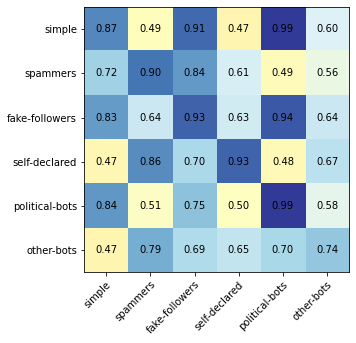

In [1629]:
depth = 3
botometer_tootoa_a = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'accuracy', depth)
botometer_tootoa_a.to_csv(f"botometer_tootoa_a{depth}.csv")

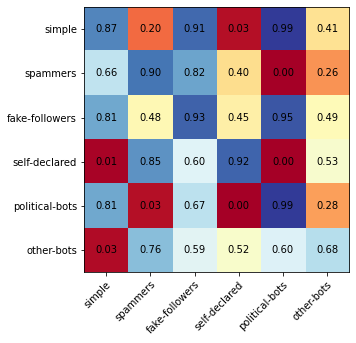

In [1630]:
depth = 3
botometer_tootoa_f = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'f1', depth)
botometer_tootoa_f.to_csv(f"botometer_tootoa_f{depth}.csv")

# Botometer combined datasets: leave-one-dataset-out

In [1633]:
cols = list(set.intersection(*map(set,[list(d) for d in botometer_datasets])))
if 'created_at' in cols:
    cols.remove("created_at")


rows = []

for i in range(len(botometer_datasets)):
    rows.append(botometer_leave_dataset_out(botometer_datasets, i))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

In [1634]:
print_leave_one_out_table(botometer_leave_one_out_scores)

simple & 0.69/0.66 & 1 \\
spammers & 0.81/0.83 & 2 \\
fake-followers & 0.91/0.91 & 3 \\
self-declared & 0.46/0.08 & 1 \\
political-bots & 0.96/0.96 & 3 \\
other-bots & 0.61/0.48 & 1 \\


# Ensemble of specialized decision trees

In [1660]:
def split_human_df(human_df, n_datasets, dataset_size):
    human_df_sample = human_df.sample(n=n_datasets*dataset_size)
    return [human_df_sample[i*dataset_size:(i+1)*dataset_size] for i in range(n_datasets)]

In [1661]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
human_dfs = split_human_df(human_df, len(botometer_datasets), dataset_size)

bot_names = [get_dataset_name(d) for d in botometer_datasets]


In [1682]:
importlib.reload(sys.modules['ensemble'])

from ensemble import get_ensemble_of_classifiers

In [1683]:
clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers(botometer_datasets, human_dfs, bot_names, depth=4)


In [1684]:
score_ensemble_speicalized_trees(clfs, test_aggregate_df, test_labels_aggregate_concat)

Accuracy using max confidences: 0.5869744435284419
Accuracy using majority vote: 0.8062654575432812
Accuracy using weighted majority vote: 0.6685902720527618
F1 using max confidences: 0.32388663967611336
F1 using majority votes: 0.7764034253092293
F1 using weighted majority votes: 0.508557457212714
Accuracy using most captured: 0.8235779060181369
Accuracy using weighted most captured: 0.8211046990931574)
F1 using most captured: 0.8099467140319716
F1 using weighted majority captured: 0.7973856209150327


## Ensembles of specialized random forests

In [1686]:
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers(botometer_datasets, human_dfs, bot_names, method=rf)

predictions = [rf_clfs[i].predict(test_aggregate_df) for i in range(n_classifiers)]
probs = [rf_clfs[i].predict_proba(test_aggregate_df) for i in range(n_classifiers)]
probs = [p[:,0] for p in probs]
most_confident_clf = [get_max_confidence_rf(probs, i)[0] for i in range(len(test_aggregate_df))]
max_prediction = [predictions[j][i] for i,j in enumerate(most_confident_clf)]
print(f"Accuracy: {accuracy_score(max_prediction, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(max_prediction, test_labels_aggregate_concat)}")

Accuracy: 0.5919208573784006
F1: 0.2998585572842999


## Just simple decision rule

In [1687]:
all_clf = clfs[-1]
all_predictions = all_clf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions, test_labels_aggregate_concat)}")

Accuracy: 0.8252267106347898
F1: 0.8062157221206582


## Just random forest

In [1688]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions_rf, test_labels_aggregate_concat)}")

Accuracy: 0.887881286067601
F1: 0.8800705467372133


## Testing on held-out set

In [1689]:
hold_out_test_df = pd.concat([cresci_stock_2018_one_hot[cols], cresci_rtbust_2019_one_hot[cols], gilani_2017_one_hot[cols]])
hold_out_test_labels = pd.concat([cresci_stock_labels, rtbust_labels, gilani_labels])

score_ensemble_speicalized_trees(clfs, hold_out_test_df, hold_out_test_labels)


Accuracy using max confidences: 0.6582078678970374
Accuracy using majority vote: 0.5419499757163672
Accuracy using weighted majority vote: 0.607030111704711
F1 using max confidences: 0.629556520594815
F1 using majority votes: 0.6788131624877612
F1 using weighted majority votes: 0.6920112290050912
Accuracy using most captured: 0.550692083535697
Accuracy using weighted most captured: 0.5520883924235066)
F1 using most captured: 0.6755228199394975
F1 using weighted majority captured: 0.6796908917252756


In [1690]:
score_ensemble_speicalized_trees(clfs, cresci_stock_2018_one_hot[cols], cresci_stock_labels)

Accuracy using max confidences: 0.6844682133172643
Accuracy using majority vote: 0.5534046399517927
Accuracy using weighted majority vote: 0.6180325399216632
F1 using max confidences: 0.6898185857089967
F1 using majority votes: 0.7029410291096749
F1 using weighted majority votes: 0.7263799708627852
Accuracy using most captured: 0.5602591141910214
Accuracy using weighted most captured: 0.5604097619764989)
F1 using most captured: 0.7046443387635334
F1 using weighted majority captured: 0.7048052604957005


In [1691]:
score_ensemble_speicalized_trees(clfs, cresci_rtbust_2019_one_hot[cols], rtbust_labels)

Accuracy using max confidences: 0.5411255411255411
Accuracy using majority vote: 0.5180375180375181
Accuracy using weighted majority vote: 0.6031746031746031
F1 using max confidences: 0.39543726235741444
F1 using majority votes: 0.6744639376218322
F1 using weighted majority votes: 0.6609124537607892
Accuracy using most captured: 0.5238095238095238
Accuracy using weighted most captured: 0.5238095238095238)
F1 using most captured: 0.6751968503937009
F1 using weighted majority captured: 0.6758349705304518


In [1692]:
score_ensemble_speicalized_trees(clfs, gilani_2017_one_hot[cols], gilani_labels)

Accuracy using max confidences: 0.5513383939272872
Accuracy using majority vote: 0.48781462245305635
Accuracy using weighted majority vote: 0.5497403116260487
F1 using max confidences: 0.037703513281919454
F1 using majority votes: 0.48842777334397447
F1 using weighted majority votes: 0.3263598326359832
Accuracy using most captured: 0.5073911306432282
Accuracy using weighted most captured: 0.5157810627247303)
F1 using most captured: 0.39171188949185987
F1 using weighted majority captured: 0.4603739982190561


In [1693]:
all_predictions = all_clf.predict(hold_out_test_df)
print(f"Accuracy: {accuracy_score(all_predictions, hold_out_test_labels)}")
print(f"F1: {f1_score(all_predictions, hold_out_test_labels)}")

Accuracy: 0.5428606119475473
F1: 0.6736586634307012


In [1694]:
all_predictions = all_clf.predict(cresci_stock_2018_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, cresci_stock_labels)}")
print(f"F1: {f1_score(all_predictions, cresci_stock_labels)}")

Accuracy: 0.5508436275986743
F1: 0.7020734449163127


In [1695]:
all_predictions = all_clf.predict(cresci_rtbust_2019_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, rtbust_labels)}")
print(f"F1: {f1_score(all_predictions, rtbust_labels)}")

Accuracy: 0.5238095238095238
F1: 0.6771037181996086


In [1696]:
all_predictions = all_clf.predict(gilani_2017_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, gilani_labels)}")
print(f"F1: {f1_score(all_predictions, gilani_labels)}")

Accuracy: 0.5057930483419896
F1: 0.39273441335297005


In [1697]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(hold_out_test_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, hold_out_test_labels)}")
print(f"F1: {f1_score(all_predictions_rf, hold_out_test_labels)}")

Accuracy: 0.5622875182127246
F1: 0.6783260462211119


In [1698]:
all_predictions_rf = all_clf_rf.predict(cresci_stock_2018_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, cresci_stock_labels)}")
print(f"F1: {f1_score(all_predictions_rf, cresci_stock_labels)}")

Accuracy: 0.566812292859295
F1: 0.7066564651874522


In [1699]:
all_predictions_rf = all_clf_rf.predict(cresci_rtbust_2019_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, rtbust_labels)}")
print(f"F1: {f1_score(all_predictions_rf, rtbust_labels)}")

Accuracy: 0.5367965367965368
F1: 0.6603174603174603


In [1700]:
all_predictions_rf = all_clf_rf.predict(gilani_2017_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, gilani_labels)}")
print(f"F1: {f1_score(all_predictions_rf, gilani_labels)}")

Accuracy: 0.5453455852976429
F1: 0.3894849785407725
